# Exploring Kicker Average and Consistency

The ability to perform well in individual matches at critical moments is important, but consistently performing at a high level of skill creates a statistical divide between lucky players and highly skilled players. As a result, measuring empirical variance is an important aspect to determining a player’s skill level.

## Prepare Data

Get kickers play data from data base with play, player and game information
(where distance kicked from is >=35 yards)

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.mlab as mlab
from mysql.connector import errorcode
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output

%matplotlib inline

def getData():
    config = {
    'user': 'db_gtown_2018',
    'password': '*****',
    'port': '3306',
    'host': 'nflnumbers.czuayagz62va.us-east-1.rds.amazonaws.com',
    'database': 'db_nfl',
    'raise_on_warnings': True,
    }

    try:
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
        #Let's read all the rows in the table
        readContactPerson = """SELECT 
        FKICKER,
        Percentage.GID,
        FGXP,
        ((SUM(SUCCESS) / COUNT(*)) * 100) AS SUCCESS_PRCNTG,
        ((SUM(BLOCKED) / COUNT(*)) * 100) AS BLOCKED_PRCNTG,
        COUNT(*) AS PLAY_COUNT,
        CASE
            WHEN SUM(HIGH_PRESSURE) = 0 THEN 0
            ELSE ((SUM(HIGH_PRESSURE_SUCCESS) / SUM(HIGH_PRESSURE)) * 100)
        END AS HIGH_PRESSURE_SUCCESS_PRCNTG,
        CASE
            WHEN SUM(LONG_DIST) = 0 THEN 0
            ELSE ((SUM(LONG_DIST_SUCCESS) / SUM(LONG_DIST)) * 100)
        END AS LONG_DIST_SUCCESS_PRCNTG,    
        TEMP,
        HUMD,
        WSPD,
        COND,
        SURF,
        (YEAR(CURDATE()) - PLAYER.start) AS YEARS_PLAYED,
        height,
        weight,
        PLAYER.forty,
        PLAYER.bench,
        PLAYER.vertical,
        PLAYER.broad,
        PLAYER.shuttle,
        PLAYER.cone,
        PLAYER.arm,
        PLAYER.hand,
        PLAYER.dcp,
        DPOS AS DRAFT_POSITION,
        (SELECT 
                (TO_DAYS(NOW()) - TO_DAYS(STR_TO_DATE(dob, '%m/%d/%Y'))) / 365
            FROM
                PLAYER P
            WHERE
                P.player = FKICKER) AS AGE_YEARS
    FROM
        (SELECT 
            FGXP,
                PBP.GID,
                PBP.FKICKER,
                CASE
                    WHEN GOOD = 'Y' THEN 1
                    ELSE 0
                END AS SUCCESS,
                CASE
                    WHEN UPPER(DETAIL) LIKE '%BLOCKED%' THEN 1
                    ELSE 0
                END AS BLOCKED,
                CASE
                    WHEN
                        QTR IN ('2' , '4') AND MIN <= 2
                            AND (PTSO - PTSD) >= - 3
                    THEN
                        1
                    ELSE 0
                END AS HIGH_PRESSURE,
                CASE
                    WHEN
                        QTR IN ('2' , '4') AND MIN <= 2
                            AND (PTSO - PTSD) >= - 3
                            AND GOOD = 'Y'
                    THEN
                        1
                    ELSE 0
                END AS HIGH_PRESSURE_SUCCESS,
                CASE
                    WHEN DIST >= 50 THEN 1
                    ELSE 0
                END AS LONG_DIST,
                CASE
                    WHEN DIST >= 50 AND GOOD = 'Y' THEN 1
                    ELSE 0
                END AS LONG_DIST_SUCCESS,
                DIST - (100 - CASE
                    WHEN YFOG = '' THEN '98'
                    ELSE YFOG
                END) AS YDS_BEHIND_LOS
        FROM
            PBP
        LEFT OUTER JOIN PLAYER PLAYER ON PBP.FKICKER = PLAYER.PLAYER
        WHERE
            TYPE = 'FGXP' AND POS1 = 'K'
                AND DIST >= 35) AS Percentage
            LEFT OUTER JOIN
        PLAYER PLAYER ON Percentage.FKICKER = PLAYER.PLAYER
            LEFT OUTER JOIN
        GAME ON Percentage.GID = GAME.GID
    GROUP BY FKICKER , Percentage.GID
    ORDER BY FKICKER , Percentage.GID;"""
        cursor.execute(readContactPerson)
        #specify the attributes that you want to display
        df = DataFrame(cursor.fetchall())    
        df.columns = ['FKICKER','GID','FGXP','SUCCESS_PRCNTG','BLOCKED_PRCNTG','PLAY_COUNT',
        'HIGH_PRESSURE_SUCCESS_PRCNTG','LONG_DIST_SUCCESS_PRCNTG',
        'TEMP','HUMD','WSPD','COND','SURF',
        'YEARS_PLAYED','height','weight','forty','bench',
        'vertical','broad','shuttle','cone',
        'arm','hand','dcp','DRAFT_POSITION','AGE_YEARS']
        cnx.commit()
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    else:
        
        return df
        cursor.close()
        cnx.close()
data = getData()        

In [2]:
data.head(3)

,FKICKER,GID,FGXP,SUCCESS_PRCNTG,BLOCKED_PRCNTG,PLAY_COUNT,HIGH_PRESSURE_SUCCESS_PRCNTG,LONG_DIST_SUCCESS_PRCNTG,TEMP,HUMD,...,bench,vertical,broad,shuttle,cone,arm,hand,dcp,DRAFT_POSITION,AGE_YEARS
0,AD-0800,14,FG,100.0000,0.0000,1,0,0,73,78,...,0,0.0,0,0.0,0.0,0,0.0,0,0,56.2274
1,AD-0800,28,FG,100.0000,0.0000,1,0,0,80,84,...,0,0.0,0,0.0,0.0,0,0.0,0,0,56.2274
2,AD-0800,54,FG,100.0000,0.0000,2,0,0,61,0,...,0,0.0,0,0.0,0.0,0,0.0,0,0,56.2274


In [3]:
data.size

173556

## Analyse, Clean and Transfrom data

In [4]:
# Check number of missing values
data.isnull().sum()

FKICKER                         0
GID                             0
FGXP                            0
SUCCESS_PRCNTG                  0
BLOCKED_PRCNTG                  0
PLAY_COUNT                      0
HIGH_PRESSURE_SUCCESS_PRCNTG    0
LONG_DIST_SUCCESS_PRCNTG        0
TEMP                            0
HUMD                            0
WSPD                            0
COND                            0
SURF                            0
YEARS_PLAYED                    0
height                          0
weight                          0
forty                           0
bench                           0
vertical                        0
broad                           0
shuttle                         0
cone                            0
arm                             0
hand                            0
dcp                             0
DRAFT_POSITION                  0
AGE_YEARS                       0
dtype: int64

### Analyse Weather conditions

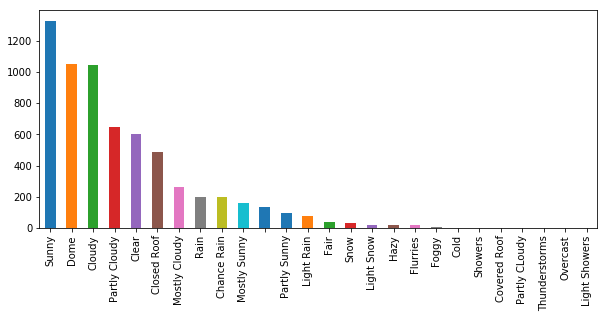

In [5]:
plt.figure(figsize=(10,4))
data["COND"].value_counts().plot(kind='bar')

too many weather conditions, map these conditions to fewer categories

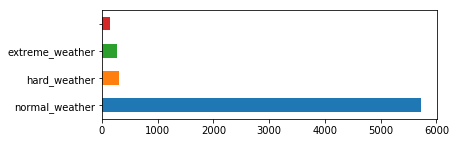

In [6]:
WeatherConditionsDifficultyLevel = {
    'unknown_weather': '',
    'normal_weather':['Closed Roof','Covered Roof','Dome','Clear','Cloudy',
              'Partly Cloudy','Mostly Cloudy','Fair','Partly CLoudy',
              'Sunny','Mostly Sunny','Partly Sunny'],
    'hard_weather':['Chance Rain','Light Rain','Flurries','Light Snow','Light Showers'],
    'extreme_weather':['Rain','Showers','Snow','Foggy','Hazy','Thunderstorms','Cold',
               'Windy','Overcast']
}

def get_weather_category(dict, text):
    for k,v in dict.items():        
        for val in dict[k]:
            if(val == text):
                return k
    return text
dfc = data.apply(lambda row: get_weather_category(WeatherConditionsDifficultyLevel, row['COND']), axis=1)
data["WeatherCondition"] = dfc
plt.figure(figsize=(6,2))
data["WeatherCondition"].value_counts().plot(kind='barh')

In [7]:
data["WeatherCondition"].value_counts()

normal_weather     5721
hard_weather        308
extreme_weather     262
                    137
Name: WeatherCondition, dtype: int64

There are few unknown or blank weather category records, we can either make a copy of whole data and remove these empty category records from that copy and analyse this data copy or we can put normal instead of blank category, if avergae success rate of normal category and blank category is same. 
In this excercise we just want to see player performace in different categories, so we can also keep this unknown category, we may need to fill these missing values when we will predict performace.

Now let's create dummy column for each weather category and then use these column to get success percentage in each category.

In [8]:
ddf=pd.concat([data,pd.get_dummies(data["WeatherCondition"])], axis=1)

In [9]:
ddf.head(3)

,FKICKER,GID,FGXP,SUCCESS_PRCNTG,BLOCKED_PRCNTG,PLAY_COUNT,HIGH_PRESSURE_SUCCESS_PRCNTG,LONG_DIST_SUCCESS_PRCNTG,TEMP,HUMD,...,arm,hand,dcp,DRAFT_POSITION,AGE_YEARS,WeatherCondition,,extreme_weather,hard_weather,normal_weather
0,AD-0800,14,FG,100.0000,0.0000,1,0,0,73,78,...,0,0.0,0,0,56.2274,normal_weather,0,0,0,1
1,AD-0800,28,FG,100.0000,0.0000,1,0,0,80,84,...,0,0.0,0,0,56.2274,normal_weather,0,0,0,1
2,AD-0800,54,FG,100.0000,0.0000,2,0,0,61,0,...,0,0.0,0,0,56.2274,hard_weather,0,0,1,0


## Calculate averages and consistency ratings
For averages we can consider/use player mean success percentage in each game.<br/>
To measure player consistency, we borrow a concept from probability theory called the coefficient of variation (CV). This measures a player’s standardized performance dispersion. Since this is a rather large and normal sample, this model uses the unbiased form of the coefficient of variation equation:

(1+1/4n)(Std_dev/mean)

The result of this means that lower CV values result in less variation in performance, indicating a higher degree of consistency. As the CV increases, players become less and less consistent. This means we now have an empirical range with which we can determine the ability of players to perform consistently at a given level of performance.

In [10]:
data.columns

Index(['FKICKER', 'GID', 'FGXP', 'SUCCESS_PRCNTG', 'BLOCKED_PRCNTG',
       'PLAY_COUNT', 'HIGH_PRESSURE_SUCCESS_PRCNTG',
       'LONG_DIST_SUCCESS_PRCNTG', 'TEMP', 'HUMD', 'WSPD', 'COND', 'SURF',
       'YEARS_PLAYED', 'height', 'weight', 'forty', 'bench', 'vertical',
       'broad', 'shuttle', 'cone', 'arm', 'hand', 'dcp', 'DRAFT_POSITION',
       'AGE_YEARS', 'WeatherCondition'],
      dtype='object')

In [11]:
cdf= data[['FKICKER','PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','LONG_DIST_SUCCESS_PRCNTG']]
cdf[['PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','LONG_DIST_SUCCESS_PRCNTG']] = cdf[['PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','LONG_DIST_SUCCESS_PRCNTG']].apply(pd.to_numeric)
cdf.head(3)

c:\users\deepak\anaconda3\envs\gtulab\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,FKICKER,PLAY_COUNT,SUCCESS_PRCNTG,BLOCKED_PRCNTG,HIGH_PRESSURE_SUCCESS_PRCNTG,LONG_DIST_SUCCESS_PRCNTG
0,AD-0800,1,100.0,0.0,0.0,0.0
1,AD-0800,1,100.0,0.0,0.0,0.0
2,AD-0800,2,100.0,0.0,0.0,0.0


In [18]:
from IPython.html.widgets import *
import plotly as py
import plotly.graph_objs as go
    
def plot_pyplots(desc):
    py.offline.init_notebook_mode(connected=True)

    trace0 = go.Scatter(
        x = avg,
        y = cv,
        name = 'Players',
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'rgba(152, 100, 0, .8)',
            line = dict(
                width = .25,
                color = 'rgb(0, 0, 0)'
            )
        )
    )

    layout = dict(title = 'Consistency Vs Average' + desc,
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )
    
    fig= go.Figure(data=[trace0], layout=layout)
    py.offline.iplot(fig)

def plotPlayers(desc):
    fig=plt.figure(figsize=(15,6))
    fig.suptitle('Consistency Vs Average' + desc, fontsize=20)
    plt.xlabel('Average')
    plt.ylabel('Consistency')
    #plt.xticks(np.arange(0, 101, 5.0))
    #plt.yticks(np.arange(0, 8, .5))
    # plot()
    plt.plot(avg, cv, 'ro')
    # HORIZONTAL
    plt.axhline(y=cv.max()/2)#, xmin=avg.min(), xmax=avg.max(), linewidth=2, color = 'k')
    # VERTICAL
    plt.axvline(x=avg.max()/2)#, ymin=cv.min(), ymax = cv.max(), linewidth=2, color='k')
    plt.show()
    
#def filterData(ch=0, count=0,cond=0):
def filterData(kicks=0):
    global result,cv,avg

    #if(ch=='Any'):
    result = cdf.groupby(['FKICKER'], as_index=False).agg(
        {'PLAY_COUNT':['sum'],'SUCCESS_PRCNTG':['mean','std']})
    result.columns = ['FKICKER','PLAY_COUNT','SUCCESS_PRCNTG_MEAN','SUCCESS_PRCNTG_STD']
    result.reindex(columns=sorted(result.columns))
    result['SUCCESS_PRCNTG_CV'] = result['SUCCESS_PRCNTG_STD']/result['SUCCESS_PRCNTG_MEAN']
    result = result[result['PLAY_COUNT']>kicks]
    cv = 1/result['SUCCESS_PRCNTG_CV']
    avg = result['SUCCESS_PRCNTG_MEAN']
    plot_pyplots('')    
        #xy_chart.add('Player', [(row.SUCCESS_PRCNTG_MEAN,row.SUCCESS_PRCNTG_CV) for index,row in result.iterrows()])       

    #elif(ch=='Long Distance'):
    result = cdf.groupby(['FKICKER'], as_index=False).agg(
        {'PLAY_COUNT':['sum'],'LONG_DIST_SUCCESS_PRCNTG':['mean','std']})
    result.columns = ['FKICKER','PLAY_COUNT','LONG_DIST_SUCCESS_PRCNTG_MEAN','LONG_DIST_SUCCESS_PRCNTG_STD']
    result.reindex(columns=sorted(result.columns))
    result['LONG_DIST_SUCCESS_PRCNTG_CV'] = result['LONG_DIST_SUCCESS_PRCNTG_STD']/result['LONG_DIST_SUCCESS_PRCNTG_MEAN']
    result = result[result['PLAY_COUNT']>kicks]
    cv = 1/result['LONG_DIST_SUCCESS_PRCNTG_CV']
    avg = result['LONG_DIST_SUCCESS_PRCNTG_MEAN']
    plot_pyplots('- > 50 Yards')
    #elif(ch=='High Pressure'):
    result = cdf.groupby(['FKICKER'], as_index=False).agg(
        {'PLAY_COUNT':['sum'],'HIGH_PRESSURE_SUCCESS_PRCNTG':['mean','std']})
    result.columns = ['FKICKER','PLAY_COUNT','HIGH_PRESSURE_SUCCESS_PRCNTG_MEAN','HIGH_PRESSURE_SUCCESS_PRCNTG_STD']
    result.reindex(columns=sorted(result.columns))
    result['HIGH_PRESSURE_SUCCESS_PRCNTG_CV'] = result['HIGH_PRESSURE_SUCCESS_PRCNTG_STD']/result['HIGH_PRESSURE_SUCCESS_PRCNTG_MEAN']
    result = result[result['PLAY_COUNT']>kicks]
    cv = 1/result['HIGH_PRESSURE_SUCCESS_PRCNTG_CV']
    avg = result['HIGH_PRESSURE_SUCCESS_PRCNTG_MEAN']    
    plot_pyplots('- High Pressure') 
#c=interactive(filterData,ch=['Any','High Pressure', 'Long Distance'],
#              count=(0,100,1),cond=['Any', 'Normal', 'Hard', 'Extreme'])
c=interactive(filterData,kicks=(0,100,1))
display(c)

interactive(children=(IntSlider(value=0, description='kicks'), Output()), _dom_classes=('widget-interact',))